In [1]:
import os
import pickle

import sys
sys.path.append('..')

import numpy as np

from data_loader.load_data import ImagesLoader

from simpsons_classifier.simpsons_classifier import SimpsonsClassifier
import simpsons_classifier.load_stacking_models as stack
from simpsons_classifier.voter import Voter as vote

from challenge.simpsons import *

from utils.colors import Colors

from sklearn.metrics import classification_report, \
                            confusion_matrix, \
                            ConfusionMatrixDisplay

from sklearn.metrics import f1_score
from skopt import gp_minimize
from skopt.plots import plot_convergence

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
print(sys.version)

3.9.8 (main, Nov 10 2021, 03:02:59) 
[GCC 10.2.1 20210110]


# **CARREGANDO OS DADOS**

In [4]:
# selecionando os dados desejados

DATASET_NAME = 'simpsons-small-balanced'

LOAD_FIELDS = [
    'images_hsv',
    'images_h',
    'images_s',
    'images_v',
    'descriptor_h',
    'descriptor_s',
    'descriptor_v',
    'descriptor_hsv',
    'descriptor_hu',
    'descriptor_lbp',
    'combination_hsv+hu',
    'combination_hsv+lbp+hu'
]

MODEL_FIELDS = [
    'combination_hsv+hu',
    'descriptor_hsv'
]

In [5]:
# carregando os dados

loader = ImagesLoader(train_images_path=f'../data/{DATASET_NAME}/train/',
                      test_images_path=f'../data/{DATASET_NAME}/test/')

data = loader.load_data(load_list=LOAD_FIELDS)

# with open(f'../data/{DATASET_NAME}/{DATASET_NAME}.pkl', 'rb') as infile:
#     data = pickle.load(infile)

+ 'names_files' loaded
+ 'names_paths' loaded
+ 'names_characters' loaded
+ 'names_encoded' loaded
+ 'images_original' loaded
+ 'images_resized' loaded
+ 'images_gray' loaded
- 'images_blue' not in load list
- 'images_green' not in load list
- 'images_red' not in load list
+ 'images_hsv' loaded
+ 'images_h' loaded
+ 'images_s' loaded
+ 'images_v' loaded
- 'images_lbp' not in load list
- 'images_hu' not in load list
- 'images_gabor' not in load list
- 'images_hog' not in load list
- 'descriptor_blue' not in load list
- 'descriptor_green' not in load list
- 'descriptor_red' not in load list
- 'descriptor_rgb' not in load list
+ 'descriptor_h' loaded
+ 'descriptor_s' loaded
+ 'descriptor_v' loaded
+ 'descriptor_hsv' loaded
+ 'descriptor_lbp' loaded
+ 'descriptor_hu' loaded
- 'descriptor_gabor' not in load list
- 'descriptor_hog' not in load list
- 'combination_rgb+hsv' not in load list
- 'combination_rgb+hsv+lbp' not in load list
- 'combination_rgb+hsv+hu' not in load list
- 'combination_

In [6]:
# shape dos dados

print('names_characters')
print(np.array(data['names_characters']['train']).shape,
      np.array(data['names_characters']['test']).shape, end='\n\n')

for field in MODEL_FIELDS:
      print(f'{field} shape =',
            np.array(data[field]['train']).shape,
            np.array(data[field]['test']).shape)

names_characters
(324,) (95,)

combination_hsv+hu shape = (324, 775) (95, 775)
descriptor_hsv shape = (324, 768) (95, 768)


# **CARREGANDO NOMES DOS ARQUIVOS**

In [7]:
# os arquivos carregados pela função 'load_data'
# são os mesmos de 'train.txt' e 'test.txt'?

# carregando os dados dos txts

X_train_files, y_train_files = load_train_data('../challenge/train.txt')
X_test_files, y_test_files = load_test_data('../challenge/test.txt')

print(X_train_files.shape, y_train_files.shape)
print(X_test_files.shape, y_test_files.shape)

(324,) (324,)
(95,) (95,)


In [8]:
# os dados carregados dos arquivos são iguais aos
# carregados pela função

print(all(data['names_paths']['train'] == X_train_files))
print(all(data['names_paths']['test'] == X_test_files))

print(all(data['names_encoded']['train'] == y_train_files))
print(all(data['names_encoded']['test'] == y_test_files))

True
True
True
True


# **TRAIN-TEST SPLIT**

In [9]:
# train-test split

X_train = [data[field]['train'] for field in MODEL_FIELDS]
y_train = data['names_encoded']['train']

X_test = [data[field]['test'] for field in MODEL_FIELDS]
y_test = data['names_encoded']['test']

# **CRIANDO O MODELO**

In [10]:
# carregando modelos instanciados

stacks = stack.load_stacking_models(fields=MODEL_FIELDS)

# cada campo representa uma stack
list(stacks.keys())

['combination_hsv+hu', 'descriptor_hsv']

In [11]:
# criação e treinamento do modelo

simp = SimpsonsClassifier(stack_models=stacks)
simp.fit(X_train, y_train)

preds = simp.predict(X_test)
preds_proba = simp.predict_proba(X_test)

In [12]:
# # save model to disk

# SimpsonsClassifier.save_model_to_disk(
#     model=simp,
#     path='../simpsons_classifier/',
#     filename='simpsons_classifier.sav'
# )

In [29]:
# carregando modelo do disco

simp_loaded = SimpsonsClassifier.load_model_from_disk(
    path='../simpsons_classifier/simpsons_classifier.sav'
)

In [ ]:
# otimização nos pesos
weights, weighted_f1 = vote.hard_voting_random_optimization(
    preds=preds,
    y_test=y_test,
    n=10000,
    verbose=True
)

weight f1 = 0.7809368191721133
[[1 1 4]
 [4 3 3]
 [3 2 1]
 [2 3 4]
 [1 2 3]]


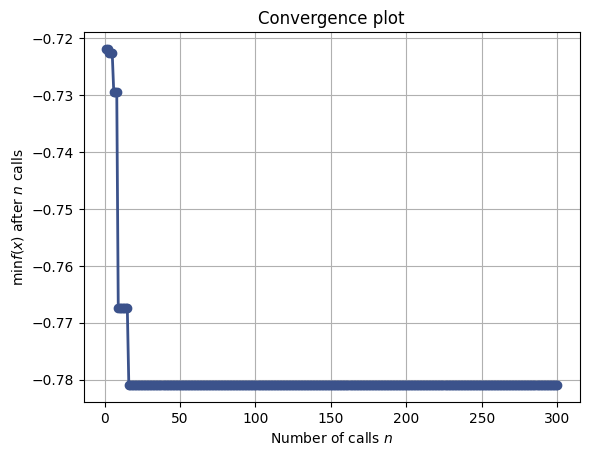

In [52]:
def vote_predict(params):
    weights = np.array(params).reshape(5,3)
    weights = weights.tolist()

    y_pred = vote.hard_voting(list(preds.values()),
                              weights=weights)

    f1 = f1_score(y_test, y_pred, average='weighted')

    return -f1

space = [[1, 4] for i in range(15)]

# gaussian process optimization
result = gp_minimize(
    vote_predict,
    space,
    random_state=42,
    verbose=0,
    n_calls=300,
    n_random_starts=10
)

print('weight f1 =', abs(result.fun))
print(np.array(result.x).reshape(5,3))

plot_convergence(result);

In [55]:
# pesos para cada campo e cada classe
# caso não deseje rodar a otimização

weights = [[1, 1, 4],
           [4, 3, 3],
           [3, 2, 1],
           [2, 3, 4],
           [1, 2, 3]]

In [56]:
# realizando uma votação entre as três
# listas de predições distintas de cada stack

y_pred = vote.hard_voting(list(preds.values()),
                          weights=weights)

# y_pred = vote.soft_voting(list(preds.values()))

y_pred

array([0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 0, 1,
       0, 2, 2, 1, 1, 2, 2, 2, 4, 2, 4, 1, 4, 4, 4, 4, 2, 0, 0, 3, 3, 3,
       3, 3, 1, 3, 3, 1, 0])

              precision    recall  f1-score   support

           0       0.79      0.94      0.86        35
           1       0.76      0.88      0.81        25
           2       0.64      0.54      0.58        13
           3       1.00      0.70      0.82        10
           4       1.00      0.50      0.67        12

    accuracy                           0.79        95
   macro avg       0.84      0.71      0.75        95
weighted avg       0.81      0.79      0.78        95



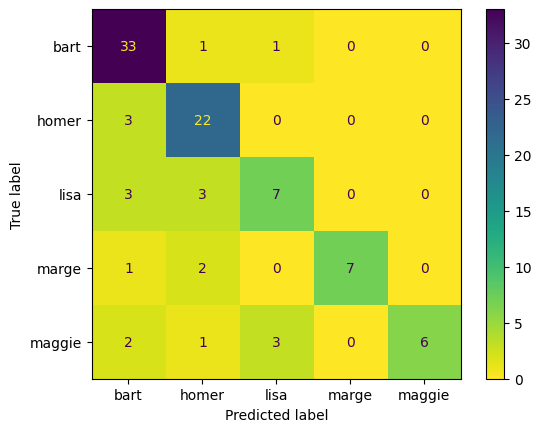

In [57]:
# resultados

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_plot = ConfusionMatrixDisplay(cm, display_labels=loader.labels)
cm_plot.plot(cmap='viridis_r');

# **LENDO O ARQUIVO DE PREDIÇÕES**

In [59]:
# lendo o arquivo de predições
# e conferindo os resultados

with open('../challenge/output.txt', 'r') as f:
    fpreds = f.read()
    fpreds = fpreds.strip()
    fpreds = fpreds.split('\n')
    fpreds = np.array([int(i.split(' ')[1]) for i in fpreds])

fpreds

array([0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 0, 1,
       0, 2, 2, 1, 1, 2, 2, 2, 4, 2, 4, 1, 4, 4, 4, 4, 2, 0, 0, 3, 3, 3,
       3, 3, 1, 3, 3, 1, 0])

              precision    recall  f1-score   support

           0       0.79      0.94      0.86        35
           1       0.76      0.88      0.81        25
           2       0.64      0.54      0.58        13
           3       1.00      0.70      0.82        10
           4       1.00      0.50      0.67        12

    accuracy                           0.79        95
   macro avg       0.84      0.71      0.75        95
weighted avg       0.81      0.79      0.78        95



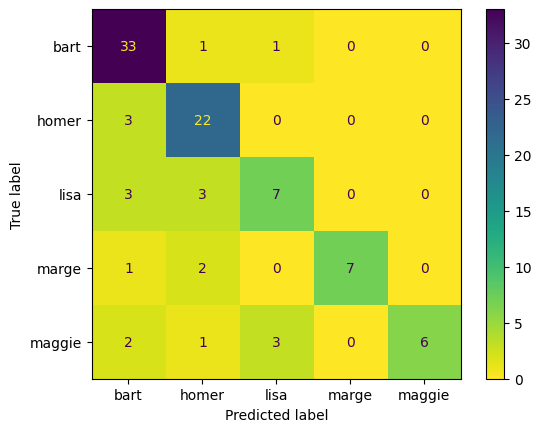

In [60]:
print(classification_report(y_test, fpreds))

cm = confusion_matrix(y_test, fpreds)
cm_plot = ConfusionMatrixDisplay(cm, display_labels=loader.labels)
cm_plot.plot(cmap='viridis_r');

In [61]:
# as predições geradas são iguais às do arquivo txt?

print(all(y_pred == fpreds))

print('percentual igual =',
      np.count_nonzero(y_pred == fpreds) / len(y_pred == fpreds))

y_pred == fpreds

True
percentual igual = 1.0


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

# **VALIDANDO O ARQUIVO DE PREDIÇÕES DE OUTRA FORMA**

In [62]:
with open('../challenge/output.txt', 'r') as f:
    output = f.read()
    output = output.strip()
    output = output.split('\n')

output[:5]

['../data/simpsons-small-balanced/test/bart081.bmp 0',
 '../data/simpsons-small-balanced/test/bart082.bmp 0',
 '../data/simpsons-small-balanced/test/bart083.bmp 0',
 '../data/simpsons-small-balanced/test/bart084.bmp 0',
 '../data/simpsons-small-balanced/test/bart085.bmp 0']

In [63]:
# percentual (acurácia) de casos
# onde o encode é igual ao nome
# real do personagem

classes = {
    0: 'bart',
    1: 'homer',
    2: 'lisa',
    3: 'marge',
    4: 'maggie'
}

# acurácia obtida

sum(
    [1 if classes[int(line.split(' ')[1])] \
          in line.split('/')[4].split('.')[0] \
       else 0 for line in output]
) / len(output)

0.7894736842105263

# **VALIDANDO OS DADOS CARREGADOS**

In [23]:
with open(f'../data/{DATASET_NAME}/{DATASET_NAME}.pkl', 'rb') as infile:
    data_loaded = pickle.load(infile)

In [24]:
for field in ['train', 'test']:
    for x, y in zip(data['combination_hsv+hu'][field],
                    data_loaded['combination_hsv+hu'][field]):
        if all(x == y):
            continue
        else:
            print('erro')
            break

print('validado!')

erro
erro
validado!


In [25]:
for field in ['train', 'test']:
    for x, y in zip(data['descriptor_hsv'][field],
                    data_loaded['descriptor_hsv'][field]):
        if all(x == y):
            continue
        else:
            print('erro')
            break

print('validado!')

validado!


# **OCORREU DATA LEAKAGE?**

In [26]:
# existe alguma imagem de teste em treino?
# avaliando o nome das imagens

for train_file in data['names_files']['train']:
    for test_file in data['names_files']['test']:
        if train_file == test_file:
            print(train_file)

In [27]:
# existe alguma imagem de teste em treino?
# avaliando a matriz das imagens

for train_img in data['images_gray']['train']:
    for test_img in data['images_gray']['test']:
        if all(train_img.ravel() == test_img.ravel()):
            print(train_img)